In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Add, Activation, Flatten, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import (Dense, Dropout, Input, Conv1D, Add,
                                     Flatten, LayerNormalization, Bidirectional,
                                     LSTM, BatchNormalization)

In [2]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
else:
    print(f'Found GPU at: {device_name}')


Found GPU at: /device:GPU:0


In [3]:
# Parameters
n_bits = 256
n_symbols = n_bits // 4
n_fft = 64
n_pilots = 9
pilot_indices = [0, 8, 16, 24, 32, 40, 48, 56, 63]
pilot_value = 3 + 3j
cp_length = 16
n_taps = 3
tap_powers = [0.3, 0.8, 0.2]
snr = 20

In [4]:
def preprocess_complex_data(data):
    data_real = np.real(data)
    data_imag = np.imag(data)
    data_combined = np.stack((data_real, data_imag), axis=-1)
    return data_combined

def postprocess_complex_data(data):
    return data[:, 0] + 1j * data[:, 1]

In [5]:
def generate_data(n_samples=1000,snr_db = 20, pilot_vals = 3+3j):
    # snr_db = 20
    # pilot_vals = 3 + 3j
    pilot_indices = np.array([0, 8, 16, 24, 32, 40, 48, 56, 63])

    Y = []
    H = []
    Y_pilot = []
    H_pilot = []
    for i in range(n_samples):
        bits = np.random.randint(0, 16, 55)
        qam = np.sqrt(1 / 10) * (2 * (bits % 4) - 3 + 1j * (2 * (bits // 4) - 3))
        data_symbols = np.zeros(64, dtype=complex)
        data_symbols[np.delete(np.arange(64), pilot_indices)] = qam
        data_symbols[pilot_indices] = pilot_vals

        h = np.random.randn(3) + 1j * np.random.randn(3)
        h = h * np.array([0.3, 0.8, 0.2])
        H_FFT = np.fft.fft(h, 64)
        

        x = np.fft.ifft(data_symbols)
        x_cp = np.concatenate((x[-16:], x))

        snr = 10**(snr_db / 10)
        noise = (1 / np.sqrt(2 * snr)) * (np.random.randn(80) + 1j * np.random.randn(80))

        y = np.convolve(h, x_cp)[:80] + noise
        Y_FFT = np.fft.fft(y[16:])
        
        Yp = Y_FFT[pilot_indices]
        Hp = H_FFT[pilot_indices]

        Y.append(Y_FFT)
        Y_pilot.append(Yp)
        H_pilot.append(Hp)
        H.append(H_FFT)

        # X.append(y)
    # Y = np.array(Y)
    # H = np.array(H)
    # Y_pilot = np.array(Y_pilot)
    return Y,Y_pilot, H,H_pilot


In [6]:
def create_model(input_shape=(64, 2)):
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv1D(filters=64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional block with skip connection
    x_shortcut = x
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64 * 2, activation=None)(x)

    # Reshape the output to (64, 2)
    outputs = tf.reshape(x, (-1, 64, 2))

    model = Model(inputs=inputs, outputs=outputs)

    # Learning rate schedule
      
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mse'])
    return mode


def train_model(model, X_train, y_train, epochs=200):
    model.fit(X_train, y_train, epochs=epochs, verbose=2)

def plot_results(H, H_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(np.abs(H), label='Actual H')
    plt.plot(np.abs(H_pred), label='Predicted H', linestyle='--')
    plt.xlabel('Subcarrier index')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
## Change name of model file accordingly
checkpoint_filepath = "model_weights_20_new.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)

In [ ]:
## change SNR accordingly
snr = 20
Ytt ,b, Htt,d = generate_data(1000000,snr)
Y_train,Y_test, H_train, H_test = train_test_split(Ytt,Htt,test_size=0.1, random_state=42)
Y_train = preprocess_complex_data(Y_train)
H_train = preprocess_complex_data(H_train)

In [ ]:
model = create_model()
history = model.fit(Y_train, H_train, epochs=100, batch_size=64, validation_split=0.1,callbacks=[checkpoint_callback])

Epoch 1/100
12651/12657 [============================>.] - ETA: 0s - loss: 0.0274 - mse: 0.0274
Epoch 1: val_loss did not improve from 0.00638
12657/12657 [==============================] - 41s 3ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/100
12656/12657 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 2: val_loss did not improve from 0.00638
12657/12657 [==============================] - 38s 3ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/100
12655/12657 [============================>.] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 3: val_loss improved from 0.00638 to 0.00624, saving model to model_weights_20_new.h5
12657/12657 [==============================] - 38s 3ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/100
12651/12657 [============================>.] - ETA: 0s - loss: 0.0062 - mse: 0.0062
Epoch 4: val_loss improved from 0.00624 to 0.00623, 

KeyboardInterrupt: ignored

In [ ]:
## SAve model
model.save("model_weights_20_new.h5")

In [ ]:
test_loss, test_mse = model.evaluate(X_test_preprocessed, y_pred_preprocessed, batch_size=64)

313/313 [==============================] - 1s 3ms/step - loss: 5.8430e-14 - mse: 5.8430e-14


In [ ]:
y , h = generate_data(1,10)
y = preprocess_complex_data(y)
h = preprocess_complex_data(h)


In [ ]:
h_predict = model.predict(y)

1/1 [==============================] - 0s 19ms/step


In [ ]:
allCarriers = np.arange(64)
h_abs = np.sqrt(h[:,:,0]**2 + h[:,:,1]**2)
h_abs = np.ravel(h_abs)

h_absp = np.sqrt(h_predict[:,:,0]**2 + h_predict[:,:,1]**2)
h_absp = np.ravel(h_absp)

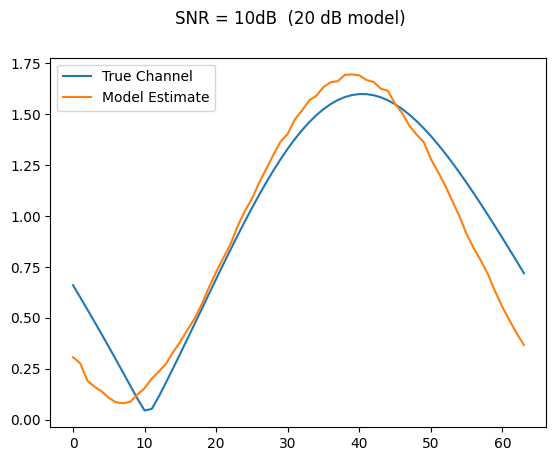

In [ ]:
plt.suptitle("SNR = 10dB  (20 dB model)")
plt.plot(allCarriers,h_abs,label ='True Channel')
plt.plot(allCarriers,h_absp,label ='Model Estimate')
plt.legend()